In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import re
import string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from langdetect import detect, LangDetectException
import contractions

# Define stop words for text cleaning
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to C:\Users\Akmal
[nltk_data]     Nazim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Akmal
[nltk_data]     Nazim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Akmal
[nltk_data]     Nazim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Load the dataset
df = pd.read_csv("cyberbullying_tweets.csv")

In [3]:
# Describe the data
df.describe()
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


(47692, 2)

In [4]:
# Checking the missing data
df.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [5]:
df.cyberbullying_type.value_counts()

cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64

In [6]:
# Clean emojis from text
def strip_emoji(text):
    return emoji.demojize(text)

# Remove punctuations, stopwords, links, mentions and new line characters
def strip_all_entities(text):
    text = re.sub(r'\r|\n', ' ', text.lower())  # Replace newline and carriage return with space, and convert to lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # Remove links and mentions
    text = re.sub(r'[^\x00-\x7f]', '', text)  # Remove non-ASCII characters
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    # Remove hashtags at the end of the sentence
    new_tweet = re.sub(r'(\s+#[\w-]+)+\s*$', '', tweet).strip()
    
    # Remove the # symbol from hashtags in the middle of the sentence
    new_tweet = re.sub(r'#([\w-]+)', r'\1', new_tweet).strip()
    
    return new_tweet

# Filter special characters such as & and $ present in some words
def filter_chars(text):
    return ' '.join('' if ('$' in word) or ('&' in word) else word for word in text.split())

# Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub(r"\s\s+", " ", text)

# Function to check if the text is in English, and return an empty string if it's not
def filter_non_english(text):
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "unknown"
    return text if lang == "en" else ""

# Expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Lemmatize words
def lemmatize(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Remove short words
def remove_short_words(text, min_len=2):
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

# Replace elongated words with their base form
def replace_elongated_words(text):
    regex_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    return re.sub(regex_pattern, r'\1\3\4', text)

# Remove repeated punctuation
def remove_repeated_punctuation(text):
    return re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)

# Remove extra whitespace
def remove_extra_whitespace(text):
    return ' '.join(text.split())

def remove_url_shorteners(text):
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', text)

# Remove spaces at the beginning and end of the tweet
def remove_spaces_tweets(tweet):
    return tweet.strip()

# Remove short tweets
def remove_short_tweets(tweet, min_words=3):
    words = tweet.split()
    return tweet if len(words) >= min_words else ""

# Function to call all the cleaning functions in the correct order
def clean_tweet(tweet):
    tweet = strip_emoji(tweet)
    tweet = expand_contractions(tweet)
    tweet = filter_non_english(tweet)
    tweet = strip_all_entities(tweet)
    tweet = clean_hashtags(tweet)
    tweet = filter_chars(tweet)
    tweet = remove_mult_spaces(tweet)
    tweet = remove_numbers(tweet)
    tweet = lemmatize(tweet)
    tweet = remove_short_words(tweet)
    tweet = replace_elongated_words(tweet)
    tweet = remove_repeated_punctuation(tweet)
    tweet = remove_extra_whitespace(tweet)
    tweet = remove_url_shorteners(tweet)
    tweet = remove_spaces_tweets(tweet)
    tweet = remove_short_tweets(tweet)
    tweet = ' '.join(tweet.split())  # Remove multiple spaces between words
    return tweet

In [7]:
df['tweet_clean'] = [clean_tweet(tweet) for tweet in df['tweet_text']]

In [8]:
df.drop_duplicates("tweet_clean", inplace=True)

In [9]:
df.cyberbullying_type.value_counts()

cyberbullying_type
religion               7917
age                    7818
ethnicity              7432
gender                 7287
not_cyberbullying      6100
other_cyberbullying    4917
Name: count, dtype: int64

In [10]:
# Data preprocessing
labEncoder = LabelEncoder()
labelsEncoded = labEncoder.fit_transform(df["cyberbullying_type"])

In [11]:
# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(df['tweet_clean'], labelsEncoded, test_size=0.2, random_state=42)
print((train_texts.shape, train_labels.shape, val_texts.shape, val_labels.shape))

# Reset indices
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)

((33176,), (33176,), (8295,), (8295,))


In [12]:
# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_texts)
X_val = vectorizer.transform(val_texts)

In [13]:
# Train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, train_labels)

LogisticRegression(max_iter=1000)

In [14]:
# Evaluate the model
val_preds = model.predict(X_val)
accuracy = accuracy_score(val_labels, val_preds)
report = classification_report(val_labels, val_preds, target_names=labEncoder.classes_)

print(f"Validation Accuracy: {accuracy:.4f}")
print(report)

Validation Accuracy: 0.8411
                     precision    recall  f1-score   support

                age       0.95      0.97      0.96      1535
          ethnicity       0.97      0.98      0.98      1481
             gender       0.91      0.84      0.87      1444
  not_cyberbullying       0.58      0.61      0.59      1257
other_cyberbullying       0.56      0.57      0.56       987
           religion       0.96      0.94      0.95      1591

           accuracy                           0.84      8295
          macro avg       0.82      0.82      0.82      8295
       weighted avg       0.84      0.84      0.84      8295



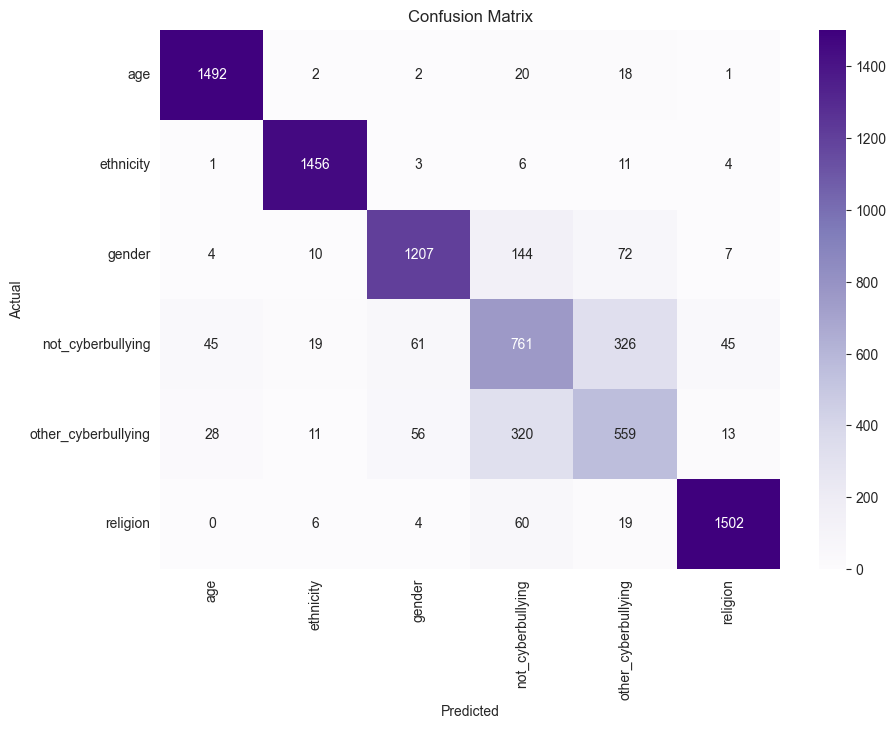

In [15]:
# Compute confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=labEncoder.classes_, yticklabels=labEncoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [16]:
def predict_class(text, model, vectorizer, classes):
    vectorized_text = vectorizer.transform([text])
    prediction = model.predict(vectorized_text)
    return classes[prediction[0]]

In [17]:
# Test predictions
for _ in range(10):
    random_idx = torch.randint(len(val_texts), size=(1,)).item()
    text, label = val_texts[random_idx], labEncoder.classes_[val_labels[random_idx]]
    prediction = predict_class(text, model, vectorizer, classes=labEncoder.classes_)
    print("=============================================")
    print(f"Text:\n{text}")
    print(f"Actual: {label}\tPredicted: {prediction}")
    print("=============================================")

Text:
society brain washed past brain fucked present black anything make world equal people colour people different belief different country would sacrifice life fuck racist
Actual: ethnicity	Predicted: ethnicity
Text:
nigger natural color dumb fuck
Actual: ethnicity	Predicted: ethnicity
Text:
lady cut coworker damn bitch watch fuck going yea dumb bitch stupid fucking nigger
Actual: ethnicity	Predicted: ethnicity
Text:
imagine coming twitter trying someone telling would bully middle school
Actual: age	Predicted: age
Text:
piece shit like everything power exterminate white people
Actual: religion	Predicted: other_cyberbullying
Text:
nm cool hot got like week left fuck think dumb amp dumber funny though niggerssmh
Actual: ethnicity	Predicted: ethnicity
Text:
racism going nowhere rt fuck obama dumb as nigger lol upset
Actual: ethnicity	Predicted: ethnicity
Text:
birtherism banning muslim denegration south american refugee calling covid china virus racist card play keep idiot leash going w